In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
#Params
batch_size=256
nbr_epochs=5
data_split_ratio=0.8
y_column = "300s"
file_price_x = "data/x_Swedbank_A_70_p.csv"
files_other_x = ["data/x_Swedbank_A_0_p_macd.csv","data/x_Swedbank_A_0_p_rsi.csv"]
file_y = "data/y_Swedbank_A_70.csv"

In [3]:
x_data = pd.read_csv(file_price_x , sep=";", dtype="float32", converters = {'ts': int})
for f in files_other_x:
    x_data = x_data.merge(pd.read_csv(f , sep=";", dtype="float32", converters = {'ts': int}), on="ts", how='inner')
y_data = pd.read_csv(file_y , sep=";", dtype="float32", converters = {'ts': int})
y_data = y_data[y_column]
del x_data["ts"]
input_size=x_data.shape[1]

<ipython-input-3-be94f3bbbf53>:1: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  x_data = pd.read_csv(file_price_x , sep=";", dtype="float32", converters = {'ts': int})
<ipython-input-3-be94f3bbbf53>:3: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  x_data = x_data.merge(pd.read_csv(f , sep=";", dtype="float32", converters = {'ts': int}), on="ts", how='inner')
<ipython-input-3-be94f3bbbf53>:4: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  y_data = pd.read_csv(file_y , sep=";", dtype="float32", converters = {'ts': int})


In [4]:
x_data.tail()

,Swedbank_A-price-0,Swedbank_A-price-1,Swedbank_A-price-2,Swedbank_A-price-3,Swedbank_A-price-4,Swedbank_A-price-5,Swedbank_A-price-6,Swedbank_A-price-7,Swedbank_A-price-8,Swedbank_A-price-9,...,Swedbank_A-price-62,Swedbank_A-price-63,Swedbank_A-price-64,Swedbank_A-price-65,Swedbank_A-price-66,Swedbank_A-price-67,Swedbank_A-price-68,Swedbank_A-price-69,Swedbank_Amacd,Swedbank_Arsi
1809204,150.779999,150.779999,150.779999,150.779999,150.779999,150.800003,150.800003,150.800003,150.800003,150.800003,...,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,0.0131,73.190399
1809205,150.779999,150.779999,150.779999,150.779999,150.779999,150.800003,150.800003,150.800003,150.800003,150.800003,...,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,0.0131,73.190399
1809206,150.779999,150.779999,150.779999,150.779999,150.800003,150.800003,150.800003,150.800003,150.800003,150.820007,...,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,0.0118,73.190399
1809207,150.800003,150.800003,150.820007,150.820007,150.820007,150.839996,150.820007,150.820007,150.779999,150.779999,...,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,0.0052,73.190399
1809208,150.800003,150.800003,150.820007,150.820007,150.820007,150.839996,150.820007,150.820007,150.779999,150.779999,...,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,150.899994,0.0052,73.190399


In [5]:
y_data.tail()

1809204    150.899994
1809205    150.899994
1809206    150.899994
1809207    150.899994
1809208    150.899994
Name: 300s, dtype: float32

In [6]:
x_data.shape

(1809209, 72)

In [7]:
y_data.shape

(1809209,)

In [8]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    d = round(len(xs[t:])/2)
    
    dev_data_x = torch.tensor(xs[t:][:d].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:][:d].values, dtype=torch.float32)
    
    test_data_x = torch.tensor(xs[t:][d:].values, dtype=torch.float32)
    test_data_y = torch.tensor(ys[t:][d:].values, dtype=torch.float32)
    
    #print(test_data_y.shape)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y), list(zip(test_data_x, test_data_y))

In [9]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#device = torch.device("cpu")
#compute_unit = "cpu"

In [10]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [11]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100).type(dtype)
        self.fc2 = nn.Linear(100, 40).type(dtype)
        self.fc3 = nn.Linear(40, 1).type(dtype)
        
        self.drop_layer = nn.Dropout(p=0.010)
    
    def forward(self, x):
        #print(x)
        fc1 = self.fc1(x)
        x = F.relu(fc1)
        x = self.drop_layer(x)
        #print(fc1)
        #print(x)
        x = F.relu(self.fc2(x))
        #print(x)
        y = F.relu(self.fc3(x))
        return y

model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

In [12]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            y = y.squeeze().type(dtype)
            x = x.squeeze().type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)  
    
    return avg_loss, predictions

In [13]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        model.train()
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            
            pred = model(x)

            loss = loss_fn(pred, y)
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [14]:
#Start training
train_data, dev_data, test_data = splitData(x_data, y_data, data_split_ratio)
train_data_loader = DataLoader(train_data, batch_size=batch_size)
dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
model = model.to(device)
train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)



/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([199])) that is different to the input size (torch.Size([199, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([185])) that is different to the input size (torch.Size([185, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the s

Epoch 0 	Loss: 5365.834 	Loss (val): 0.471
Epoch 1 	Loss: 2.012 	Loss (val): 0.683
Epoch 2 	Loss: 1.259 	Loss (val): 0.944
Epoch 3 	Loss: 1.120 	Loss (val): 1.131
Epoch 4 	Loss: 1.035 	Loss (val): 1.069
Epoch 5 	Loss: 0.967 	Loss (val): 1.075
Epoch 6 	Loss: 0.913 	Loss (val): 0.973
Epoch 7 	Loss: 0.867 	Loss (val): 1.008
Epoch 8 	Loss: 0.825 	Loss (val): 1.064
Epoch 9 	Loss: 0.803 	Loss (val): 1.088
Epoch 10 	Loss: 0.767 	Loss (val): 1.126
Epoch 11 	Loss: 0.757 	Loss (val): 1.164
Epoch 12 	Loss: 0.739 	Loss (val): 1.110
Epoch 13 	Loss: 0.728 	Loss (val): 1.134
Epoch 14 	Loss: 0.711 	Loss (val): 1.174
Epoch 15 	Loss: 0.700 	Loss (val): 1.227
Epoch 16 	Loss: 0.689 	Loss (val): 1.260
Epoch 17 	Loss: 0.681 	Loss (val): 1.369
Epoch 18 	Loss: 0.676 	Loss (val): 1.342
Epoch 19 	Loss: 0.668 	Loss (val): 1.371
Epoch 20 	Loss: 0.652 	Loss (val): 1.443
Epoch 21 	Loss: 0.650 	Loss (val): 1.505
Epoch 22 	Loss: 0.635 	Loss (val): 1.491
Epoch 23 	Loss: 0.639 	Loss (val): 1.484
Epoch 24 	Loss: 0.625 	

Epoch 198 	Loss: 0.493 	Loss (val): 1.070
Epoch 199 	Loss: 0.494 	Loss (val): 1.063
Epoch 200 	Loss: 0.497 	Loss (val): 1.059
Epoch 201 	Loss: 0.493 	Loss (val): 1.075
Epoch 202 	Loss: 0.493 	Loss (val): 1.074
Epoch 203 	Loss: 0.494 	Loss (val): 1.065
Epoch 204 	Loss: 0.493 	Loss (val): 1.073
Epoch 205 	Loss: 0.491 	Loss (val): 1.074
Epoch 206 	Loss: 0.493 	Loss (val): 1.054
Epoch 207 	Loss: 0.491 	Loss (val): 1.070
Epoch 208 	Loss: 0.492 	Loss (val): 1.079
Epoch 209 	Loss: 0.491 	Loss (val): 1.099
Epoch 210 	Loss: 0.490 	Loss (val): 1.087
Epoch 211 	Loss: 0.489 	Loss (val): 1.081
Epoch 212 	Loss: 0.488 	Loss (val): 1.090
Epoch 213 	Loss: 0.486 	Loss (val): 1.097
Epoch 214 	Loss: 0.488 	Loss (val): 1.090
Epoch 215 	Loss: 0.487 	Loss (val): 1.081
Epoch 216 	Loss: 0.488 	Loss (val): 1.093
Epoch 217 	Loss: 0.486 	Loss (val): 1.096
Epoch 218 	Loss: 0.485 	Loss (val): 1.094
Epoch 219 	Loss: 0.484 	Loss (val): 1.089
Epoch 220 	Loss: 0.486 	Loss (val): 1.097
Epoch 221 	Loss: 0.483 	Loss (val)

Epoch 394 	Loss: 0.432 	Loss (val): 1.385
Epoch 395 	Loss: 0.431 	Loss (val): 1.383
Epoch 396 	Loss: 0.431 	Loss (val): 1.385
Epoch 397 	Loss: 0.431 	Loss (val): 1.386
Epoch 398 	Loss: 0.431 	Loss (val): 1.386
Epoch 399 	Loss: 0.431 	Loss (val): 1.393
Epoch 400 	Loss: 0.430 	Loss (val): 1.389
Epoch 401 	Loss: 0.430 	Loss (val): 1.391
Epoch 402 	Loss: 0.430 	Loss (val): 1.394
Epoch 403 	Loss: 0.430 	Loss (val): 1.391
Epoch 404 	Loss: 0.430 	Loss (val): 1.396
Epoch 405 	Loss: 0.430 	Loss (val): 1.403
Epoch 406 	Loss: 0.429 	Loss (val): 1.402
Epoch 407 	Loss: 0.429 	Loss (val): 1.401
Epoch 408 	Loss: 0.429 	Loss (val): 1.404
Epoch 409 	Loss: 0.429 	Loss (val): 1.406
Epoch 410 	Loss: 0.428 	Loss (val): 1.408
Epoch 411 	Loss: 0.428 	Loss (val): 1.413
Epoch 412 	Loss: 0.428 	Loss (val): 1.414
Epoch 413 	Loss: 0.428 	Loss (val): 1.419
Epoch 414 	Loss: 0.429 	Loss (val): 1.425
Epoch 415 	Loss: 0.428 	Loss (val): 1.424
Epoch 416 	Loss: 0.428 	Loss (val): 1.427
Epoch 417 	Loss: 0.427 	Loss (val)

In [15]:
_, preds = evaluate_model(test_data, model, loss_fn)

/home/oscar/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


162.6060333251953


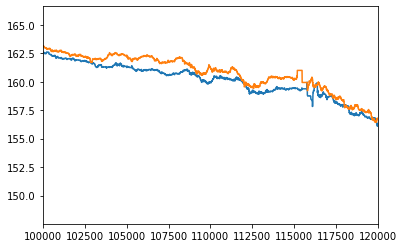

In [17]:
y_data_borpi = list(zip(*test_data))
print(preds[10001])
items_plot = [y_data_borpi[1][t] for t in range(len(y_data_borpi[1]))]
plt.plot(list(range(len(preds))), preds)
plt.plot(list(range(len(items_plot))), items_plot)
axes = plt.gca()
#axes.set_ylim([145,170])
#axes.set_xlim([250000,265000])
axes.set_xlim([100000,120000])
#axes.set_xlim([140000,160000])
plt.show()